<a href="https://colab.research.google.com/github/rodsmorales/Entregas/blob/main/Proyecto_Final_Software.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow opencv-python pillow

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime

# Cargar MobileNetV2 para detección de personas
base_model_personas = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_personas.trainable = False

# Agregar capas para la clasificación de personas
x = base_model_personas.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions_personas = Dense(1, activation='sigmoid')(x)

# Crear el modelo de detección de personas
modelo_personas = Model(inputs=base_model_personas.input, outputs=predictions_personas)
modelo_personas.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Cargar EfficientNetB0 para detección de cascos
base_model_cascos = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model_cascos.trainable = False

# Agregar capas para la clasificación de cascos
x = base_model_cascos.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions_cascos = Dense(1, activation='sigmoid')(x)

# Crear el modelo de detección de cascos
modelo_cascos = Model(inputs=base_model_cascos.input, outputs=predictions_cascos)
modelo_cascos.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
def predecir_imagen(imagen):
    # Redimensionar la imagen a 128x128
    imagen_redimensionada = cv2.resize(imagen, (128, 128))
    # Normalizar la imagen
    imagen_normalizada = imagen_redimensionada / 255.0
    # Expandir dimensiones para que coincida con la entrada del modelo
    imagen_input = np.expand_dims(imagen_normalizada, axis=0)

    # Detectar si es una persona
    prediccion_persona = modelo_personas.predict(imagen_input)
    if prediccion_persona < 0.5:  # Si no es una persona
        return "No es una persona"

    # Si es una persona, predecir si lleva casco
    prediccion_casco = modelo_cascos.predict(imagen_input)
    return "Con casco" if prediccion_casco > 0.5 else "Sin casco"

In [ ]:
from datetime import datetime, timedelta

# Función para obtener la hora de Santa Cruz, Bolivia (UTC-4)
def obtener_hora_santa_cruz():
    # Obtener la hora UTC actual
    hora_utc = datetime.utcnow()
    # Ajustar la hora a UTC-4 (Santa Cruz, Bolivia)
    hora_santa_cruz = hora_utc - timedelta(hours=4)
    return hora_santa_cruz.strftime("%Y-%m-%d %H:%M:%S")

# Ejemplo de uso
hora_santa_cruz = obtener_hora_santa_cruz()
print(f"Hora en Santa Cruz, Bolivia: {hora_santa_cruz}")

Hora en Santa Cruz, Bolivia: 2025-05-05 10:07:48


<IPython.core.display.Javascript object>

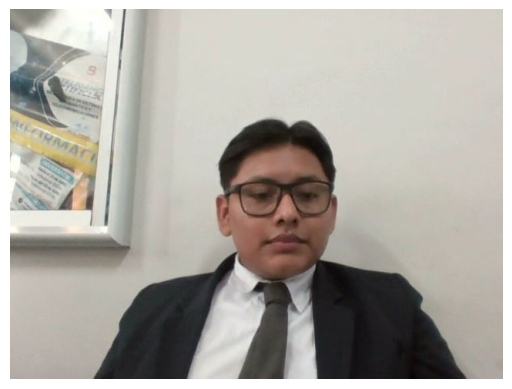

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Resultado: Con casco
Fecha y Hora en Santa Cruz, Bolivia: 2025-05-05 11:09:40


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from datetime import datetime, timedelta

# Función para obtener la hora de Santa Cruz, Bolivia
def obtener_hora_santa_cruz():
    hora_utc = datetime.utcnow()
    hora_santa_cruz = hora_utc - timedelta(hours=4)
    return hora_santa_cruz.strftime("%Y-%m-%d %H:%M:%S")

def tomar_foto():
    # Código JavaScript para acceder a la cámara
    js = Javascript('''
        async function tomarFoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Redimensionar el video para que coincida con el tamaño de la imagen
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Esperar a que el usuario tome la foto
            await new Promise((resolve) => setTimeout(resolve, 2000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')
    display(js)
    # Obtener la foto en base64
    foto_b64 = eval_js('tomarFoto()')
    # Convertir la foto a un array de numpy
    foto_bytes = b64decode(foto_b64.split(',')[1])
    foto_array = np.frombuffer(foto_bytes, dtype=np.uint8)
    foto = cv2.imdecode(foto_array, flags=1)

    # Obtener la hora de Santa Cruz, Bolivia
    fecha_hora = obtener_hora_santa_cruz()

    return foto, fecha_hora

# Tomar una foto
foto, fecha_hora = tomar_foto()
# Mostrar la foto
plt.imshow(cv2.cvtColor(foto, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Predecir si es una persona y si lleva casco
resultado = predecir_imagen(foto)
print(f"Resultado: {resultado}")
print(f"Fecha y Hora en Santa Cruz, Bolivia: {fecha_hora}")

In [ ]:
from google.colab import files
from datetime import datetime, timedelta

# Función para obtener la hora de Santa Cruz, Bolivia
def obtener_hora_santa_cruz():
    hora_utc = datetime.utcnow()
    hora_santa_cruz = hora_utc - timedelta(hours=4)
    return hora_santa_cruz.strftime("%Y-%m-%d %H:%M:%S")

# Subir una imagen
uploaded = files.upload()

# Leer la imagen
for nombre_archivo in uploaded.keys():
    imagen = cv2.imdecode(np.frombuffer(uploaded[nombre_archivo], np.uint8), 1)

    # Obtener la hora de Santa Cruz, Bolivia
    fecha_hora = obtener_hora_santa_cruz()

    # Mostrar la imagen
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Predecir si es una persona y si lleva casco
    resultado = predecir_imagen(imagen)
    print(f"Resultado: {resultado}")
    print(f"Fecha y Hora en Santa Cruz, Bolivia: {fecha_hora}")

TypeError: 'NoneType' object is not subscriptable